# <a href="https://mipt-stats.gitlab.io/courses/ad_fivt.html">Введение в анализ данных</a>
## Домашнее задание 3. Сбор и анализ данных.

- [<a href="https://mipt-stats.gitlab.io/courses/ad_fivt.html">Введение в анализ данных</a>](#<a-href="https://mipt-stats.gitlab.io/courses/ad_fivt.html">Введение-в-анализ-данных</a>)
    * [Работа с URL](attachment:./#Работа-с-URL)
    * [Анализ сайта](attachment:./#Анализ-сайта)
    * [Цель исследования](attachment:./#Цель-исследования)
    * [Распределение количества слов](attachment:./#Распределение-количества-слов)
    * [Визуализация страниц](attachment:./#Визуализация-страниц)
    * [Новый критерий](attachment:./#Новый-критерий)
    * [Выводы](attachment:./#Выводы)

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from url_normalize import url_normalize
from urllib.parse import urljoin
from urllib.request import urlopen
from bs4 import BeautifulSoup
from queue import Queue
import time

sns.set(style='darkgrid', font_scale=1.3, palette='Set2')
%matplotlib inline

### Задача 3.
#### Работа с URL
В данной задаче вам предстоит распарсить сайт, который вы выберeте.

Прочитайте, как именно функция `url_normalize` меняет ссылку, и приведите примеры $4$ урлов, которые нормализуются к одному и тому же. Примеры должны демонстрировать различные этапы процедуры нормализации. Одним из этих примеров может быть сам нормализованный урл.

In [3]:
print(url_normalize('http://www.example.com/z%C2%B1b'))
print(url_normalize('HTTP://www.example.com/z%C2%B1b'))
print(url_normalize('http://www.example.com:80/z%C2%B1b'))
print(url_normalize('http://www.example.com/z%c2%b1b'))

http://www.example.com/z%C2%B1b
http://www.example.com/z%C2%B1b
http://www.example.com/z%C2%B1b
http://www.example.com/z%C2%B1b


#### Анализ сайта

Изучите код, в котором скачиваются страницы сайта `simple.wikipedia.org` с <a href="https://mipt-stats.gitlab.io/courses/ad_fivt/data_parsing.html">занятия про парсинг данных</a> и **скопируйте его в решение данной задачи**. Код, реализующий обход в ширину с фильтрацией и нормализацией урлов, приведён в виде функции.

Код обхода в ширину:

In [9]:
def load_web_pages(seed, max_downloads, filtration_function):
    """Обходит web-страницы в ширину и загружает информацию о них.
    
    Принимает:
        seed (str) -- страница, с которой начинать обход.
        max_downloads (int) -- максимальное число загруженных страниц.
        filtration_function (str -> bool) -- функция, указывающая, 
            стоит ли загружать страницу. Пример: is_wiki_article.
            
    Возвращает:
        pages_json (list) - список словарей с информацией о страницах.
    """

    # Создаём cписки с интересующими данными
    pages_json = []
    num_links = []
    download_time = []
    deep_level = []
    
    # Создаём очередь для обхода в ширину
    q = Queue()
    # Второй аргумент - глубина
    q.put((seed, 0))

    already_visited = set()
    n_downloads = 0

    while not q.empty():
        # Нормализуем урл
        url_queue, level = q.get()
        main_url = url_normalize(url_queue)
        if main_url in already_visited:
            continue
        already_visited.add(main_url)
        
        start = time.time()
        html = download_from_the_internet(main_url)
        end = time.time()
        
        if html is None or main_url is None:
            continue
  
        # Извлекаем ссылки из страницы
        children_links = extract_links_from_html(main_url, html)
        time.sleep(1)

        # Извлекаем текст страницы
        text_info = extract_text_info_from_html(html)

        # Добавляем запись в таблицу
        text_info['url'] = main_url
        
        pages_json.append(text_info)
        num_links.append(len(children_links))
        download_time.append(end - start)
        deep_level.append(level)

        n_downloads += 1
        if n_downloads > max_downloads:
            break
          
        # Добавляем ещё не посещённые ссылки в очередь
        for child in children_links:
            if url_normalize(child) not in already_visited \
            and filtration_function(child):
                q.put([child, level + 1])
    
    data = pd.DataFrame(pages_json)
    data['link_count'] = pd.DataFrame(num_links)
    data['download_time'] = pd.DataFrame(download_time)
    data['deep'] = pd.DataFrame(deep_level)

    return data

In [4]:
def download_from_the_internet(url):
    try:
        return urlopen(url).read().decode('utf-8')
    except KeyboardInterrupt:
        raise
    except:
        return None


def extract_links_from_html(url, html):
    parser = BeautifulSoup(html)
    return [urljoin(url, link.get('href')) for link in parser.findAll('a')]


def extract_text_info_from_html(html):
    soup = BeautifulSoup(html, features="html.parser")
    for script in soup(["script", "style"]):
        script.extract()

    text = soup.get_text()
    lines = (line.strip() for line in text.splitlines())
    chunks = (phrase.strip() for line in lines for phrase in line.split("  "))
    text = '\n'.join(chunk for chunk in chunks if chunk)

    title = soup.find('title').string

    return {'text': text, 'title': title}


def is_codeforces(url):
    """Проверяет, является ли ссылка страницей на codeforces"""
    if 'codeforces' not in url:
        return False
    return True

#### Цель исследования

**2.** Выберите достаточно крупный сайт, который вам интересен, а также некоторую категорию страниц в нём. Поймите, с какой страницы сайта надо начать обход, чтобы обходить сайты данной категории.

**Укажите, что выбрали:**
Ищу задачи страницы с условиями задач на https://codeforces.com, начинаю со страницы https://codeforces.com/problemset/

Придумайте критерий, который по тексту из HTML-страницы будет определять, находится ли страница в определённой вами категории.

**Опишите критерий:** 
На странице должно быть 'ограничение по времени на тест' или 'time limit per test'

Начав с выбранной страницы, скачайте не менее $500$ страниц сайта. В качестве функции фильтрации возьмите функцию, которая отделяет страницы с выбранного сайта от других.

In [5]:
def criteria(text):
    if 'ограничение по времени на тест' in text or 'time limit per test' in text:
        return True
    return False

Cделайте `pandas`-таблицу со следующей информацией:

* количество слов в тексте статьи;
* принадлежит ли страница выбранной категории.

Для последнего пункта можете воспользоваться функцией поиска слов по заданным префиксам, рассмотренной на <a href="https://mipt-stats.gitlab.io/courses/ad_fivt/data_parsing.html">занятии</a>.

In [8]:
SEED = "https://codeforces.com/problemset"
n = 500
cf_data = load_web_pages(SEED, n, is_codeforces)

Определите, какой процент скачанных страниц принадлежит выбранной категории:

In [9]:
cf_data_copy = cf_data.copy()

# определяю принадлежность target
cf_data_copy['target'] = cf_data_copy['text'].apply(lambda x: False if criteria(x) == False else True)

total_number = cf_data_copy.shape[0]
target_number = cf_data_copy[cf_data_copy.target == True].shape[0]

In [10]:
print(target_number)
print(total_number)
print(target_number / total_number)

100
501
0.1996007984031936


**Таким образом, принадлежит $19.6\%$ процентов загруженных страниц.**

#### Распределение количества слов

C помощью гистограмм сравните визуально распределения количества слов в статьях из выбранной категории и во всех остальных.

Для этих двух распределений вычислите средние, медианы и дисперсии. Средние и медианы отобразите на графиках с гистограммами. Сделайте выводы.

In [12]:
# считаю слова
cf_data_copy['word_count'] = cf_data_copy['text'].apply(lambda x: len(x.split()))
cf_data_copy.head()

target_pages = cf_data_copy[cf_data_copy['target'] == True]
not_target_pages = cf_data_copy[cf_data_copy['target'] == False]

# уберём выбросы по нетаргетированным страницам
q1 = not_target_pages['word_count'].quantile(0.25)
q3 = not_target_pages['word_count'].quantile(0.75)

not_target_pages = not_target_pages[(not_target_pages['word_count'] > q1) & (not_target_pages['word_count'] < q3)]

Вычислим среднее, медианы и дисперсии. Для целевой категории:

In [13]:
tp_describe = target_pages.describe()
tp_median = np.median(target_pages['word_count'])
tp_describe

,link_count,download_time,deep,word_count
count,100.000000,100.000000,100.0,100.000000
mean,32.220000,0.376697,1.0,660.750000
std,3.119117,0.051379,0.0,204.234831
min,31.000000,0.290247,1.0,383.000000
25%,31.000000,0.340494,1.0,525.500000
50%,31.000000,0.365093,1.0,594.000000
75%,31.000000,0.397039,1.0,719.750000
max,41.000000,0.512200,1.0,1116.000000


Для нецелевой категории:

In [14]:
ntp_describe = not_target_pages.describe()
ntp_median = np.median(not_target_pages['word_count'])
ntp_describe

,link_count,download_time,deep,word_count
count,169.000000,169.000000,169.000000,169.000000
mean,334.065089,0.637715,1.189349,1072.473373
std,266.484904,0.499624,0.407817,277.417020
min,29.000000,0.305082,0.000000,476.000000
25%,187.000000,0.454535,1.000000,1006.000000
50%,189.000000,0.512029,1.000000,1054.000000
75%,420.000000,0.701687,1.000000,1162.000000
max,957.000000,5.506915,2.000000,2208.000000


Выведем требуемые величины:

In [15]:
# медианы
print(tp_median)
print(ntp_median)
# дисперсии
print(tp_describe['word_count']['std'] ** 2)
print(ntp_describe['word_count']['std'] ** 2)

594.0
1054.0
41711.86616161616
76960.20315581851


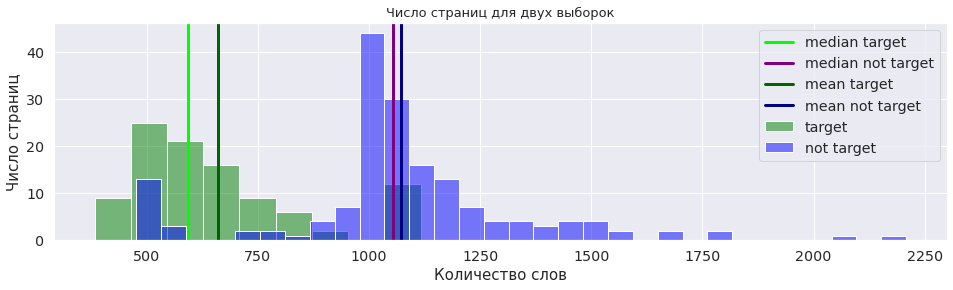

In [61]:
plt.rcParams["figure.figsize"] = (16, 4)

# основные графики
sns.histplot(x=target_pages['word_count'], color='green', alpha = 0.5, label='target')
sns.histplot(x=not_target_pages['word_count'], color='blue', alpha = 0.5, label='not target')

# медиана
plt.axvline(tp_median, 0, 40, linewidth = 3, color='lime', label='median target')
plt.axvline(ntp_median, 0, 40, linewidth = 3, color='purple', label='median not target')

# средняя
plt.axvline(tp_describe['word_count']['mean'], 0, 40, linewidth = 3, color='darkgreen', label='mean target')
plt.axvline(ntp_describe['word_count']['mean'], 0, 40, linewidth = 3, color='navy', label='mean not target')

plt.xlabel('Количество слов', fontsize = 15)
plt.ylabel('Число страниц', fontsize = 15)
plt.title('Число страниц для двух выборок', fontsize = 13)
plt.legend()

**Выводы:**
Поскольку данные для нецелевого сектора статей были избавлены от выбросов, то различие между медианой и средним не столь велико, как в целевой категории. В среднем, целевая категория статей имеет $550-600$ слов, а нецелевая $1000-1100$.

Постройте boxplot-графики для того, чтобы сравнить эти 2 распределения. Какой способ сравнения кажется вам более удобным?

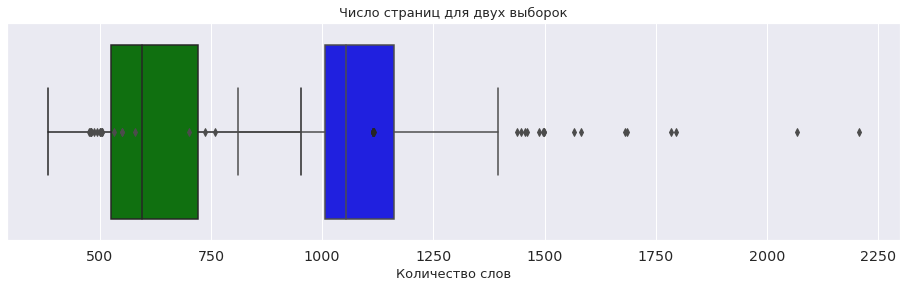

In [70]:
plt.rcParams["figure.figsize"] = (16, 4)
fig, ax = plt.subplots()
sns.boxplot(x=target_pages['word_count'], color='green')
sns.boxplot(x=not_target_pages['word_count'], color='blue')

plt.xlabel('Количество слов', fontsize = 13)
plt.title('Число страниц для двух выборок', fontsize = 13)

**Мнение:** Мне кажется, что график более нагляден и лучше демонстрирует динамику.

#### Визуализация страниц

**3.** Визуализируйте скачанные страницы сайта. В качестве значений по осям возьмите количество слов на странице и количество ссылок на ней. Цветом обозначьте принадлежность выбранной вами категории. 

In [78]:
# уберём выбросы по ссылкам
q1 = cf_data_copy['word_count'].quantile(0.25)
q3 = cf_data_copy['word_count'].quantile(0.75)
cp = cf_data_copy[(cf_data_copy['word_count'] > q1) & (cf_data_copy['word_count'] < q3)]

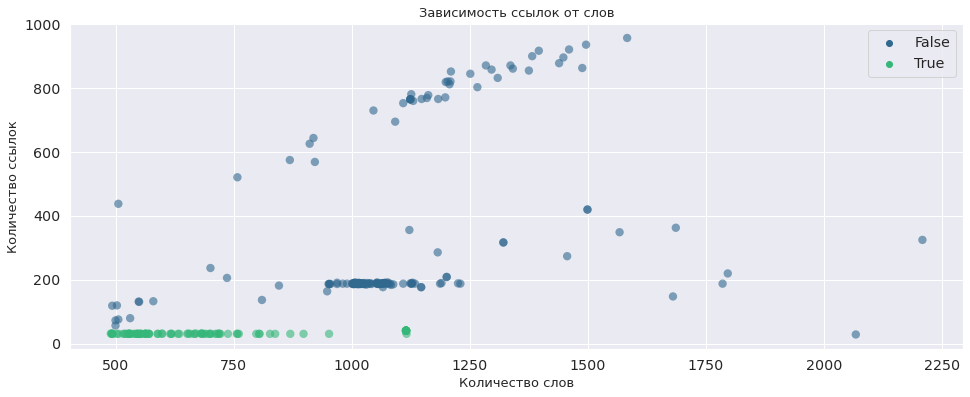

In [86]:
plt.figure(figsize = (16, 6))

fig = sns.scatterplot(
    data=cp,
    x='word_count',
    y='link_count',
    s=70,
    linewidth=0, 
    hue='target',
    palette='viridis',
    alpha=0.6,
    )

plt.xlabel('Количество слов', fontsize = 13)
plt.ylabel('Количество ссылок', fontsize = 13)
plt.title('Зависимость ссылок от слов', fontsize = 13)
plt.legend()

**Вывод:** Таким образом, целевые страницы содержат в среднем $30-33$ ссылки, а иные страницы обладают сильным разбросом, хотя среди них также можно выделить смысловые группы. 

#### Новый критерий

**4.** Предложите функцию фильтрации web-страниц, которую нужно подать в `load_web_pages`, чтобы среди скачанных сайтов был больше процент страниц из выбранной вами категории.

In [40]:
def is_task_page(url):
    """Проверяет, является ли ссылка страницей с задачей на codeforces"""

    if 'codeforces' in url and 'problem' in url:
        prohibited = ['status', 'submit']
        # Проверяем, есть ли запрещённые строки в ссылке
        for token in prohibited:
            if token in url:
                return False
        return True

    return False

Скачайте снова не менее $500$ страниц, но уже с новой функцией фильтрации. Добавьте следующую информацию к каждой странице:

* глубина в обходе,
* время скачивания страницы.

Для замера времени можете воспользоваться функцией `time` из пакета `time`.

In [42]:
cf_data_new_criteria = load_web_pages(SEED, n, is_task_page)

In [43]:
cf_new_data_copy = cf_data_new_criteria.copy()
cf_new_data_copy['target'] = cf_new_data_copy['text'].apply(lambda x: False if criteria(x) == False else True)

total_number_new_criteria = cf_new_data_copy.shape[0]
target_number_new_criteria  = cf_new_data_copy[cf_new_data_copy.target == True].shape[0]

cf_new_data_copy.head()

,text,title,url,link_count,download_time,deep,target
0,Problemset - Codeforces\nEnter\n|\nRegister\nH...,Problemset - Codeforces,https://codeforces.com/problemset,765,0.725019,0,False
1,Problemset - Codeforces\nEnter\n|\nRegister\nH...,Problemset - Codeforces,https://codeforces.com/problemset?locale=en,765,0.504148,1,False
2,Архив - Codeforces\nВойти\n|\nЗарегистрировать...,Архив - Codeforces,https://codeforces.com/problemset?locale=ru,766,0.464785,1,False
3,Login - Codeforces\nEnter\n|\nRegister\nHome\n...,Login - Codeforces,https://codeforces.com/enter?back=/problemset,28,0.279936,1,False
4,Problemset - Codeforces\nEnter\n|\nRegister\nH...,Problemset - Codeforces,https://codeforces.com/problemsets/acmsguru,438,0.837663,1,False


In [44]:
print(target_number_new_criteria)
print(total_number_new_criteria)
print(target_number_new_criteria / total_number_new_criteria)

263
501
0.5249500998003992


Таким образом, $52\%$ страниц принадлежат целевой группе.

Постройте гистограмму для времени скачивания страницы. Предположите, каким известным вам стандартным распределением оно может быть приближено? 

Чтобы лучше наблюдать распределение, ограничим сверху значения:

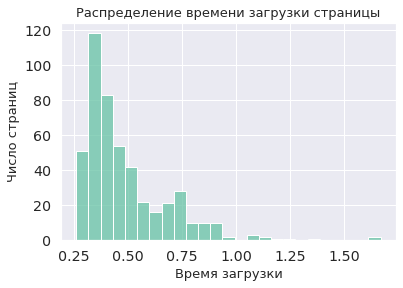

In [81]:

data = cf_new_data_copy.loc[cf_new_data_copy['download_time'] < 2]
sns.histplot(x='download_time', data=data)

plt.xlabel('Время загрузки', fontsize = 13)
plt.ylabel('Число страниц', fontsize = 13)
plt.title('Распределение времени загрузки страницы', fontsize = 13)

#### Выводы
Таким образом, гистограмма скачивания страниц напоминает гамма-распределение с параметром $\nu = 1, \lambda = 2$, умноженном на поправочный коэффициент $k=20$.

<img src="https://studfile.net/html/6745/262/html_TRTiDp2LJq.wNut/htmlconvd-Ozs5E35x1.jpg" width=400 height=250 />

Отметим, что в результате работы мы определили, что целевая категория страниц содержит $30-32$ ссылки, а нецелевая, как правило, больше. 

Второй критерий повысил эффективность до $52\%$, потому что я точечно убрала ряд нецелевых страниц.

В результате анализа, мы получили основные статистические величины по столбцам, построили гистограмму и boxplot. В связи с тем, что в нецелевой категории были сильные выбросы (например, $50 000$ ссылок на странице при медиане $600$), в ряде графиков я убрала выбивающиеся значения.